# ATLAN DATA SCIENCE ASSIGMENT

 I have divided this solution in 4 major parts- 
     1. Making the query (Based on user selection)
     2. Getting the data through the web query 
     3. Cleaning and plotting the data i.e. POI retrieved 
     4. Making the clusters ( Used 2 methods- DBSCAN and KMEANS ) 
     
     
     
I have made this notebook in a dashboard style manner, due to the rendering incmpatibility and to ensure environment flexibility, I could not add a UI dashboard or a TABLEAU dashboard in this jupyter notebook. 
But I have added easy to use interactive widgets in order to make same like a dashboard.

For the definition of a commerical centre, I have assumed that there will be a collection of places like-
1. schools 
2. libraries
3. banks
4. hospital
5. cinema halls 
6. marketplace
7. pubs 
8. cafe
9. parking areas
10. fuel stations 
11. food courts 
12. restaurants 
13. bus stations 

These are the 'amenities' available to fetch from OSM (Open Street Map) [Source: https://wiki.openstreetmap.org/wiki/Key:amenity]
<br>
<b>A high occurance of a combination of these places around a particular locality would mean that that is a commercial centre of the city.</b> 
<br>
So my plan of action in this solution is- <br>
Select categories of places to look at -> Plot them on the map -> Make clusters where they occur close to each other -> Calculte and plot the centre of those localities, thus getting the commercial centre.

## 1. MAKING THE QUERY

In [383]:
# TO add the interactive widgets 
import ipywidgets as widgets

In [384]:
# The python wrapper for OSM
import overpy
import pandas as pd

# Making an empty database that will be filled later on
header = ['name', 'type', 'lat', 'lon']
df=pd.DataFrame(columns=header)

# Making the overpy object
api = overpy.Overpass()

In [385]:
# Importing the neccessary libraries
from ipywidgets import widgets
from IPython.display import display

# Making an interactive list of what the user wants to select in his/her study
w = widgets.SelectMultiple(description="Places",
options=['school', 'library', 'bank','hospital','cinema', 'marketplace','pub', 'cafe','parking','fuel','food_court', 'restaurant','bus_station'])  # More places can be added here easily
display(w)  # User can select multiple places by holding CTRL and selecting the desired terms

SelectMultiple(description='Places', options=('school', 'library', 'bank', 'hospital', 'cinema', 'marketplace'…

In [386]:
w.value # A tuple is created

('school',
 'bank',
 'hospital',
 'marketplace',
 'cafe',
 'parking',
 'food_court',
 'bus_station')

## 2. RETRIEVING THE DATA AND CLEANING IT

In [387]:
# Function to make the query and fill it in a database and then return it to the user

def get_df(df,selection):  #Here selection is a list of user chosen places
    for ele in selection:
        print("Working on getting data about- "+ele)
        result = api.query("""
                area[name="Delhi"]->.searchArea;
        (
          node["amenity"="""+ele+"""](area.searchArea);
          way["amenity"="""+ele+"""](area.searchArea);
          relation["amenity"="""+ele+"""](area.searchArea);
        );
        out body;
        >;
        out skel qt;
            """)

        for i in range (len(result.nodes)):
            try:
                row=result.nodes[i].tags.get("name", "n/a"),result.nodes[i].tags['amenity'],result.nodes[i].lat,result.nodes[i].lon
                s = pd.Series(list(row), index=df.columns)
                df = df.append(s, ignore_index=True) # Adding the result to the dataframe
            except KeyError:
                pass

    print("!! DONE !!")
    return df # Returning the dataframe

In [388]:
# This function is used to clean the OUTLIERS of the dataframe. Due to the query fetching the result under high performance load, few outliers are noticed and so this function will clean them.

def df_cleaning(df):
    data=df.copy()
    data=df[(df.iloc[:, 2] > 27) & (df.iloc[:, 2] < 29)]  # These are the long and lat ranges for Delhi
    data=data[(data.iloc[:, 3] > 75) & (data.iloc[:, 3] < 78)]
    print("!! CLEANING DONE !!")
    return data

In [389]:
# Importing libraries to make a POINT Object out of geo cordinates
from shapely.geometry import Point, Polygon
import geopandas as gpd

In [390]:
# This function makes points out of geo cordinates.
def make_points(df):
    crs={'init':'epsg:4326'}
    geometry=[Point(xy) for xy in zip( df["lon"], df["lat"])] # Zipping together the longitudes and latitudes
    geo_df=gpd.GeoDataFrame(df,crs=crs,geometry=geometry)
    return geo_df # Returning the dataframe

All the required methods for this section are now defined, now we shall start calling them with our desided parametres.

In [391]:
choices=w.value
df=pd.DataFrame(columns=header)
df=get_df(df,choices)

Working on getting data about- school
Working on getting data about- bank
Working on getting data about- hospital
Working on getting data about- marketplace
Working on getting data about- cafe
Working on getting data about- parking
Working on getting data about- food_court
Working on getting data about- bus_station
!! DONE !!


In [392]:
# To remove the outliers and clean our data
df=df_cleaning(df)

!! CLEANING DONE !!


In [393]:
# To make the geo points as a POINT object to further plot them on the map
df=make_points(df)

In [394]:
df.head()

,name,type,lat,lon,geometry
0,Heritage International School,school,28.5084497,77.1665460,POINT (77.16655 28.50845)
1,Deep Public School,school,28.5117155,77.1634819,POINT (77.16348 28.51172)
2,n/a,school,28.4893580,77.1378574,POINT (77.13786 28.48936)
3,US Embassy School New Delhi,school,28.5983754,77.1854210,POINT (77.18542 28.59838)
12,Secondary School,school,28.5978094,77.1808404,POINT (77.18084 28.59781)


## 3. PLOTTING THE POI (POINTS OF INTEREST) 

In [395]:
# Importing libraries to plot the basemap and the clusters
import matplotlib.pyplot as plt
import matplotlib.cm
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize


In [396]:
# Function to view the basemap of DELHI
def basemap():
    street=gpd.read_file("Districts.shx")
    fig,ax = plt.subplots(figsize = (12,12))
    street.plot(ax=ax)

In [397]:
# Function to plot the scatter points based on the category of places they belong to
def scatter_points(geo_df):
    street=gpd.read_file("Districts.shx") # Setting up the base map
    fig,ax= plt.subplots(figsize=(12,12))
    street.plot(ax=ax, alpha=0.4, color="green")
    cat=set(geo_df['type']) # Making a Set of places to get unique categories chosen by the user
    for ele in cat:
        geo_df[geo_df['type']==ele].plot(ax=ax, marker="o", label=ele)
        plt.legend(prop={'size': 15}) # Adding a legend to label the categories

 THIS IS THE BASEMAP OF DELHI THAT WE WILL BE WORKING WITH


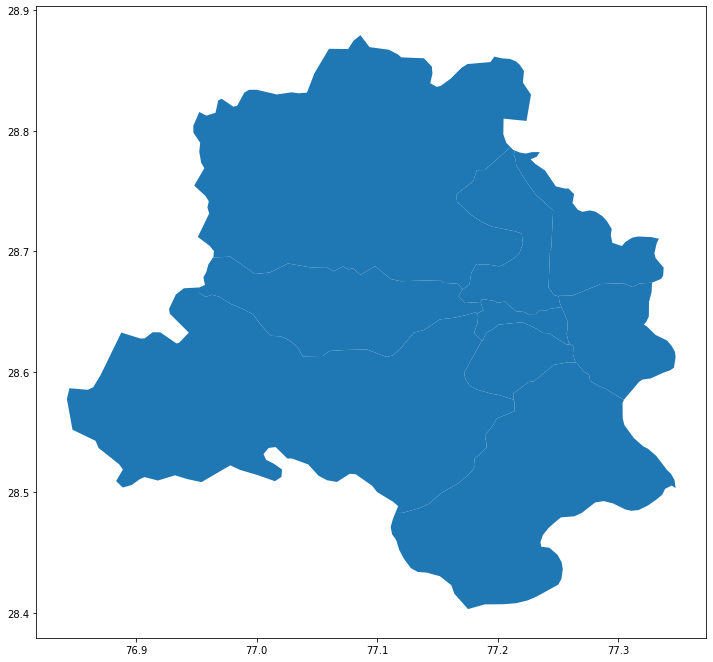

In [398]:
print(" THIS IS THE BASEMAP OF DELHI THAT WE WILL BE WORKING WITH")
basemap()

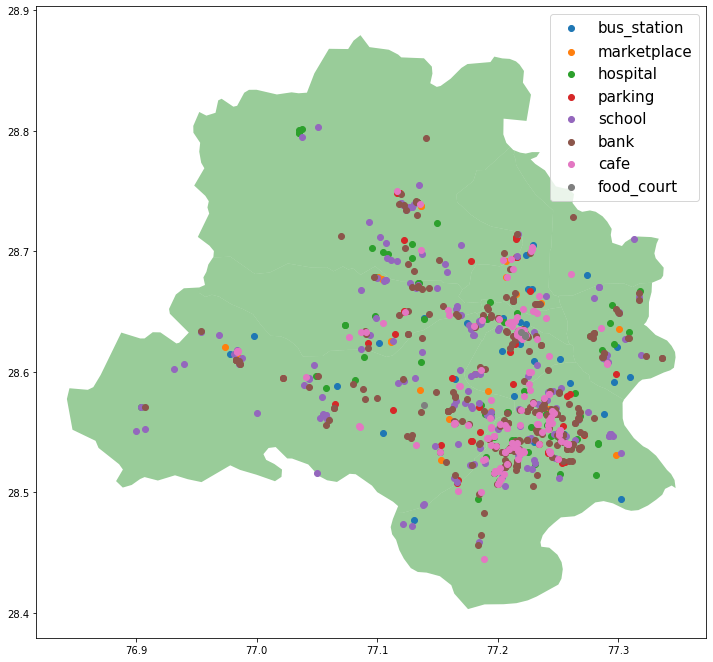

In [399]:
# To scatter all the POI on our Delhi map
scatter_points(df)

Now that we have plotted the POI on our map, we will now get to the clusteing part to identify the commercial hotspots of Delhi

## 4. MAKING THE CLUSTERS

Usually the DBSCAN clustering (DENSITY BASED CLUSTERING) is used while working with geo cordinates but the fact that our POI are plotted on a flat surface and belong to a very small range of latitudes and longitudes, the results obtained from that are not very desirable. 

<b>I have still added the working and the results obtained from DBSCAN but the main result is obtained from K MEANS CLUSTERING</b>

For the K MEANS clustering, I have <b> add an interactive slide bar to control the number of clusters the user wants to see </b>
Though we usually calculate the opimum number of clusters for KMEANS by the ELBOW METHOD, but if I would have added that then the flexibility of the solution would have decreased and also the dashbaord feature of the slide bar would not have been used. 

In the end I have added a locality wise DELHI map to see the areas which are commercial centres of the city, <b>I have not plotted the clusters on a labeled map in order to see the cluster formation clearly</b>


In [400]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np

### DBSCAN CLUSTERING- 

In [401]:
# Importing the Math functions that will be used in DBSCAN method
from math import radians, cos, sin, asin, sqrt

from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import pandas as pd

In [402]:
# Function to calculate the HAVERSHINE score for each pair of geo cordinates
# The haversine formula determines the great-circle distance between-
#   -two points on a sphere given their longitudes and latitudes
    

def haversine(lonlat1, lonlat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, lon1 = lonlat1
    lat2, lon2 = lonlat2
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in miles. We can also use 6371 for Kilometres
    return c * r

In [403]:
# Taking the columns that have lat and lon values
X=df.iloc[:,2:4]
distance_matrix = squareform(pdist(X, (lambda u,v: haversine(u,v))))

db = DBSCAN(eps=0.2, min_samples=5, metric='precomputed')  # using "precomputed" as recommended by @Anony-Mousse
y_db = db.fit_predict(distance_matrix)
X['cluster'] = y_db


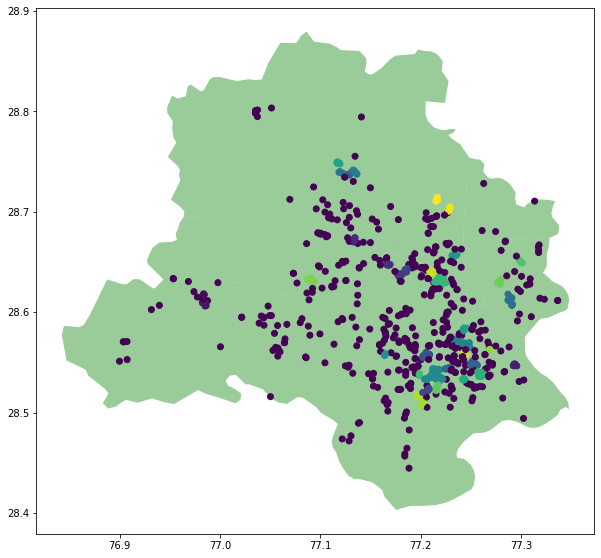

In [404]:
# Plotting the clusters formed by DBSCAN Method

fig,ax= plt.subplots(figsize=(10,10))
street=gpd.read_file("Districts.shx")
street.plot(ax=ax, alpha=0.4, color="green")
plt.scatter(X['lon'], X['lat'], c=X['cluster'])
plt.show()

As we can see that the clustering is not of much use to use. <br>
REASON- <br>
<b>DBSCAN clusters are usually calculated using the HAVERSHINE score, that is based on calculating the distance between 2 geo     cordinates taking into consideration the spherical natue of the earth.
    Because all of our poits are close to each other (With respect to the whole earth), the distance obtained will be very less     and thus most of the points will be falling under the same cluster. </b>
    
Thus we can use the classic K MEANS clustering technique. For that the interactive featues are added below

### K-MEANS CLUSTERING- 

In [412]:
def plotting(data,n):    
    X1 = data[['lat','lon']] # Taking columns of geo cordinates
    cls = KMeans(n_clusters=n, init='random')
    cls.fit(X1)
    newfeature_fare = cls.labels_ # the labels from kmeans clustering to be applied as color in scatterplot
    X1=X1.values
    centroids = np.array(cls.cluster_centers_)
    fig,(ax1,ax2)= plt.subplots(ncols=2,figsize=(15,15)) #Making the subplots
    street=gpd.read_file("Districts.shx")
    
    #Plotting the 1st subplot of clustered POI
    street.plot(ax=ax1, alpha=0.4, color="green")
    ax1.scatter(X1[:, 1], X1[:, 0], c=newfeature_fare,  cmap=plt.cm.rainbow, s=50, linewidths=1, alpha=0.7)
    plt.xlabel('Long'), plt.ylabel('Lat')
    ax1.set_title("Clusters of POI")
    
    #Plotting the 2nd sub plot of centroids of clusters obtained   
    street.plot(ax=ax2, alpha=0.4, color="green")     
    ax2.scatter(centroids[:,1], centroids[:,0])  
    ax2.set_title( "TOP "+str(n)+" DELHI COMMERCIAL CENTRES")
    plt.xlabel('Long'), plt.ylabel('Lat')
    

In [408]:
import ipywidgets as wg
from IPython.display import display

cluster=wg.IntSlider(description="clusters")
cl=wg.IntText()
print("Chose number of clusters you want-")
display(cl, cluster)
mylink=wg.jslink((cl,'value'),(cluster,'value')) # Linking the interactive widgets

Chose number of clusters you want-


IntText(value=0)

IntSlider(value=0, description='clusters')

I have added 2 graphs for the Kmeans clustering- 
1. Clusters of scattered POI to show the spatial positions of POI
2. Centroid of each POI cluster depciting the <b>commercial centre</b>

Below those 2 graphs, I have added a locality wise map of Delhi to refer to the locality that is represented by the centroids of clustered POI

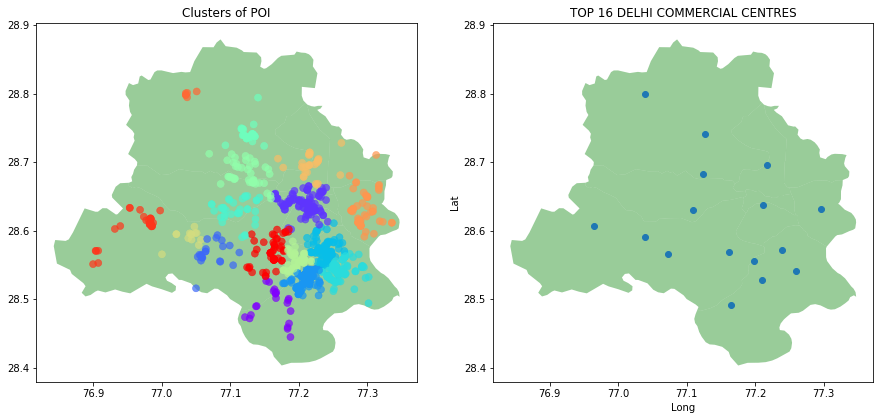

In [413]:
# Run this to getthe clusters plotted on the map  
plotting(df,cl.value)

                    HERE IS A REFERENCE IMAGE OF DELHI TO SEE THE LOCALITIES OF THE CLUSTERS
<table><tr><td><img src='delhi_map.jpg'></td></table>


I hope that I was able to express the solution in an effective way, in case of any query or some other issue please let me know. 

THank You